## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [29]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""

reduce_lr_factor = [0.5, 0.3, 0.8]
redice_lr_patient = [5,10,15]

In [30]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 7s 135us/step - loss: 1.3104 - accuracy: 0.5452 - val_loss: 1.5005 - val_accuracy: 0.4718
Epoch 11/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.2820 - accuracy: 0.5555 - val_loss: 1.4803 - val_accuracy: 0.4724
Epoch 12/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.2548 - accuracy: 0.5668 - val_loss: 1.4713 - val_accuracy: 0.4786
Epoch 13/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.2304 - accuracy: 0.5761 - val_loss: 1.4678 - val_accuracy: 0.4779
Epoch 14/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.2060 - accuracy: 0.5851 - val_loss: 1.4760 - val_accuracy: 0.4797
Epoch 15/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.1825 - accuracy: 0.5927 - val_loss: 1.4622 - val_accuracy: 0.4875
Epoch 16/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.1577 - accuracy: 0.6010 - val_loss:

batch_normalization_35 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_36 (Batc (None, 128)               512       
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,742,474
Trainable params: 1,740,682
Non-trainable params: 1,792
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 146us/step - loss: 2.2176 - accuracy: 0.2731 - val_loss: 2.0937 - val_accuracy: 0.2374
Epoch 2/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.7382 - accuracy: 0.3985 - val_loss: 1.9603 - val_accuracy: 0.3040
Epoch 3/25
50000/50000 [======================

50000/50000 [==============================] - 7s 136us/step - loss: 1.4358 - accuracy: 0.5007 - val_loss: 1.5719 - val_accuracy: 0.4471
Epoch 16/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.4202 - accuracy: 0.5055 - val_loss: 1.5639 - val_accuracy: 0.4498
Epoch 17/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.4045 - accuracy: 0.5111 - val_loss: 1.5580 - val_accuracy: 0.4552
Epoch 18/25
50000/50000 [==============================] - 8s 152us/step - loss: 1.3902 - accuracy: 0.5177 - val_loss: 1.5560 - val_accuracy: 0.4576
Epoch 19/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.3764 - accuracy: 0.5224 - val_loss: 1.5503 - val_accuracy: 0.4584
Epoch 20/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.3628 - accuracy: 0.5251 - val_loss: 1.5442 - val_accuracy: 0.4607
Epoch 21/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.3491 - accuracy: 0.5315 - val_loss:

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 145us/step - loss: 2.4413 - accuracy: 0.2150 - val_loss: 2.1952 - val_accuracy: 0.1729
Epoch 2/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.9620 - accuracy: 0.3333 - val_loss: 2.0705 - val_accuracy: 0.2580
Epoch 3/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.8149 - accuracy: 0.3731 - val_loss: 1.9607 - val_accuracy: 0.3099
Epoch 4/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.7316 - accuracy: 0.3995 - val_loss: 1.8696 - val_accuracy: 0.3412
Epoch 5/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.6734 - accuracy: 0.4185 - val_loss: 1.7870 - val_accuracy: 0.3732
Epoch 6/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.6299 - accuracy: 0.4333 - val_loss: 1.7297 - val_accuracy: 0.3909
Epoch 7/25
50000/50000 [==============================] - 7s 1

50000/50000 [==============================] - 7s 139us/step - loss: 1.3387 - accuracy: 0.5372 - val_loss: 1.5386 - val_accuracy: 0.4606
Epoch 21/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.3260 - accuracy: 0.5422 - val_loss: 1.5348 - val_accuracy: 0.4612
Epoch 22/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.3135 - accuracy: 0.5459 - val_loss: 1.5299 - val_accuracy: 0.4639
Epoch 23/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.3012 - accuracy: 0.5507 - val_loss: 1.5259 - val_accuracy: 0.4652
Epoch 24/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.2882 - accuracy: 0.5574 - val_loss: 1.5301 - val_accuracy: 0.4628
Epoch 25/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.2767 - accuracy: 0.5612 - val_loss: 1.5170 - val_accuracy: 0.4708
Numbers of exp: 8, reduce_factor: 0.80, reduce_patient: 15
Model: "model_17"
_________________________________________

50000/50000 [==============================] - 7s 144us/step - loss: 1.3152 - accuracy: 0.5382 - val_loss: 1.7490 - val_accuracy: 0.3964
Epoch 5/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.2510 - accuracy: 0.5594 - val_loss: 1.7303 - val_accuracy: 0.4033
Epoch 6/25
50000/50000 [==============================] - 7s 145us/step - loss: 1.1911 - accuracy: 0.5807 - val_loss: 1.8488 - val_accuracy: 0.3581
Epoch 7/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.1419 - accuracy: 0.5969 - val_loss: 1.9536 - val_accuracy: 0.3600
Epoch 8/25
50000/50000 [==============================] - 7s 147us/step - loss: 1.0968 - accuracy: 0.6153 - val_loss: 2.2732 - val_accuracy: 0.3140
Epoch 9/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.0598 - accuracy: 0.6306 - val_loss: 1.9722 - val_accuracy: 0.3604
Epoch 10/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.0112 - accuracy: 0.6442 - val_loss: 1.81

Epoch 22/25
50000/50000 [==============================] - 9s 172us/step - loss: 0.6376 - accuracy: 0.8059 - val_loss: 1.4885 - val_accuracy: 0.5071
Epoch 23/25
50000/50000 [==============================] - 8s 164us/step - loss: 0.6208 - accuracy: 0.8137 - val_loss: 1.4412 - val_accuracy: 0.5150
Epoch 24/25
50000/50000 [==============================] - 9s 172us/step - loss: 0.6083 - accuracy: 0.8187 - val_loss: 1.4577 - val_accuracy: 0.5150
Epoch 25/25
50000/50000 [==============================] - 8s 154us/step - loss: 0.5926 - accuracy: 0.8226 - val_loss: 1.4520 - val_accuracy: 0.5148
Numbers of exp: 11, reduce_factor: 0.50, reduce_patient: 15
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376

50000/50000 [==============================] - 8s 159us/step - loss: 1.2506 - accuracy: 0.5654 - val_loss: 1.5222 - val_accuracy: 0.4640
Epoch 7/25
50000/50000 [==============================] - 7s 150us/step - loss: 1.2065 - accuracy: 0.5832 - val_loss: 1.4635 - val_accuracy: 0.4805
Epoch 8/25
50000/50000 [==============================] - 8s 166us/step - loss: 1.1706 - accuracy: 0.5954 - val_loss: 1.4927 - val_accuracy: 0.4710
Epoch 9/25
50000/50000 [==============================] - 8s 166us/step - loss: 1.1325 - accuracy: 0.6103 - val_loss: 1.4415 - val_accuracy: 0.4861
Epoch 10/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.0974 - accuracy: 0.6245 - val_loss: 1.4258 - val_accuracy: 0.4946
Epoch 11/25
50000/50000 [==============================] - 8s 151us/step - loss: 1.0665 - accuracy: 0.6381 - val_loss: 1.4527 - val_accuracy: 0.4858
Epoch 12/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.0395 - accuracy: 0.6466 - val_loss: 1.

50000/50000 [==============================] - 9s 178us/step - loss: 1.0784 - accuracy: 0.6392 - val_loss: 1.4776 - val_accuracy: 0.4934
Numbers of exp: 14, reduce_factor: 0.30, reduce_patient: 15
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_67 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_68 (Batc (None, 256)               1024      
___________________________________________________________

50000/50000 [==============================] - 7s 148us/step - loss: 1.3269 - accuracy: 0.5452 - val_loss: 1.5087 - val_accuracy: 0.4645
Epoch 10/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.3029 - accuracy: 0.5528 - val_loss: 1.4994 - val_accuracy: 0.4749
Epoch 11/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.2817 - accuracy: 0.5589 - val_loss: 1.4875 - val_accuracy: 0.4762
Epoch 12/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.2631 - accuracy: 0.5671 - val_loss: 1.4921 - val_accuracy: 0.4745
Epoch 13/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.2436 - accuracy: 0.5735 - val_loss: 1.4770 - val_accuracy: 0.4785
Epoch 14/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.2260 - accuracy: 0.5809 - val_loss: 1.4773 - val_accuracy: 0.4815
Epoch 15/25
50000/50000 [==============================] - 8s 151us/step - loss: 1.2108 - accuracy: 0.5849 - val_loss:

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 160us/step - loss: 2.0026 - accuracy: 0.3225 - val_loss: 2.1003 - val_accuracy: 0.2438
Epoch 2/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.6428 - accuracy: 0.4262 - val_loss: 1.9293 - val_accuracy: 0.3207
Epoch 3/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.5439 - accuracy: 0.4626 - val_loss: 1.8054 - val_accuracy: 0.3630
Epoch 4/25
50000/50000 [==============================] - 7s 150us/step - loss: 1.4828 - accuracy: 0.4833 - val_loss: 1.7028 - val_accuracy: 0.4098
Epoch 5/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.4381 - accuracy: 0.4983 - val_loss: 1.6442 - val_accuracy: 0.4183
Epoch 6/25
50000/50000 [==============================] - 7s 147us/step - loss: 1.4004 - accuracy: 0.5143 - val_loss: 1.5683 - val_accuracy: 0.4510
Epoch 7/25
50000/50000 [==============================] - 8s 1

Epoch 20/25
50000/50000 [==============================] - 7s 146us/step - loss: 0.6933 - accuracy: 0.7628 - val_loss: 1.6025 - val_accuracy: 0.4824
Epoch 21/25
50000/50000 [==============================] - 7s 147us/step - loss: 0.6723 - accuracy: 0.7715 - val_loss: 1.6242 - val_accuracy: 0.4862
Epoch 22/25
50000/50000 [==============================] - 7s 145us/step - loss: 0.6475 - accuracy: 0.7807 - val_loss: 1.6473 - val_accuracy: 0.4836
Epoch 23/25
50000/50000 [==============================] - 8s 156us/step - loss: 0.6253 - accuracy: 0.7880 - val_loss: 1.6071 - val_accuracy: 0.4861

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 24/25
50000/50000 [==============================] - 7s 146us/step - loss: 0.5459 - accuracy: 0.8246 - val_loss: 1.5313 - val_accuracy: 0.5143
Epoch 25/25
50000/50000 [==============================] - 7s 144us/step - loss: 0.5252 - accuracy: 0.8321 - val_loss: 1.5354 - val_accuracy: 0.5170
Numbers of exp: 19, reduc

50000/50000 [==============================] - 7s 146us/step - loss: 1.4935 - accuracy: 0.4804 - val_loss: 1.7921 - val_accuracy: 0.3635
Epoch 4/25
50000/50000 [==============================] - 7s 147us/step - loss: 1.4126 - accuracy: 0.5099 - val_loss: 1.6561 - val_accuracy: 0.4121
Epoch 5/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.3544 - accuracy: 0.5290 - val_loss: 1.6510 - val_accuracy: 0.4150
Epoch 6/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.3016 - accuracy: 0.5489 - val_loss: 1.6321 - val_accuracy: 0.4271
Epoch 7/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.2564 - accuracy: 0.5666 - val_loss: 1.6302 - val_accuracy: 0.4232
Epoch 8/25
50000/50000 [==============================] - 7s 150us/step - loss: 1.2121 - accuracy: 0.5803 - val_loss: 1.5977 - val_accuracy: 0.4324
Epoch 9/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.1765 - accuracy: 0.5953 - val_loss: 1.551

ResourceExhaustedError:  OOM when allocating tensor with shape[1024,256] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node hidden_layer2_29/Relu (defined at c:\users\asus\env1\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_267520]

Function call stack:
keras_scratch_graph


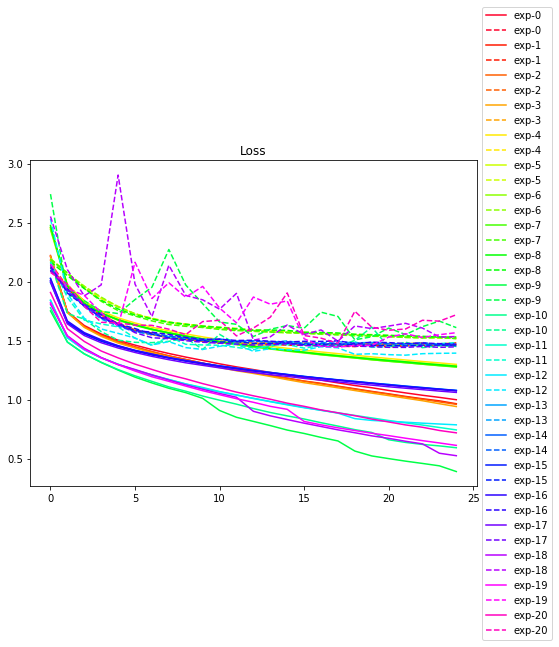

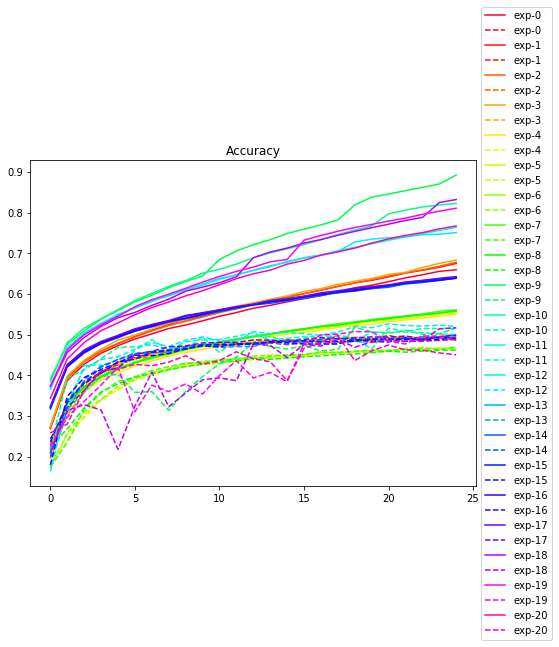

In [31]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()